In [1]:
# required by the esnb notebook framework
import esnb
from esnb import CaseGroup2, NotebookDiagnostic, RequestedVariable, nbtools
from esnb.sites.gfdl import call_dmget, convert_to_momgrid

In [2]:
# required by the diagnostic
import os

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import momgrid
import momlevel as ml
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
from matplotlib.colors import BoundaryNorm, ListedColormap
from momgrid.geoslice import geoslice

# Add the environment variable for MOMGrid weights
os.environ["MOMGRID_WEIGHTS_DIR"] = "/nbhome/jpk/grid_weights"

In [3]:
# define requested variables

variables = [
    RequestedVariable("sos", "ocean_month"),
]

In [4]:
# setup the diagnostic
mode = "prod"
verbose = True
diag_name = "SSS_bias_JRA"
diag_desc = "Sea surface salinity bias analysis"
user_options = {"plot_region": ["global"], "plot": "documentation"}

diag = NotebookDiagnostic(diag_name, diag_desc, variables=variables, **user_options)

In [5]:
# define dora ids for experiments to analyze
# ids = ["odiv-516", "odiv-384", "odiv-319", "odiv-290"]
ids = ["odiv-516", "odiv-290"]

# initialize CaseGroup objects
groups = [CaseGroup2(x, date_range=("1991-01-01", "2020-12-31")) for x in ids]

# set experiment names (mostly for labelling)
# names = [x.name for x in groups]
# names = ["b11", "b05", "b03", "b01"]
names = ["b11", "b01"]

In [6]:
# determine what files to load
diag.resolve(groups)

In [7]:
# Print a list of file paths
# This cell and the markdown cell that follows are necessary to run this notebook
# Interactively on Dora
_ = [print(x) for x in diag.files]

/archive/John.Krasting/fre_om5/FMS2025.02_om5_20250509/om5_b11_nonbouss/gfdl.ncrc6-intel23-prod/pp/ocean_monthly/ts/monthly/5yr/ocean_monthly.198801-199212.sos.nc
/archive/John.Krasting/fre_om5/FMS2025.02_om5_20250509/om5_b11_nonbouss/gfdl.ncrc6-intel23-prod/pp/ocean_monthly/ts/monthly/5yr/ocean_monthly.199301-199712.sos.nc
/archive/John.Krasting/fre_om5/FMS2025.02_om5_20250509/om5_b11_nonbouss/gfdl.ncrc6-intel23-prod/pp/ocean_monthly/ts/monthly/5yr/ocean_monthly.199801-200212.sos.nc
/archive/John.Krasting/fre_om5/FMS2025.02_om5_20250509/om5_b11_nonbouss/gfdl.ncrc6-intel23-prod/pp/ocean_monthly/ts/monthly/5yr/ocean_monthly.200301-200712.sos.nc
/archive/John.Krasting/fre_om5/FMS2025.02_om5_20250509/om5_b11_nonbouss/gfdl.ncrc6-intel23-prod/pp/ocean_monthly/ts/monthly/5yr/ocean_monthly.200801-201212.sos.nc
/archive/John.Krasting/fre_om5/FMS2025.02_om5_20250509/om5_b11_nonbouss/gfdl.ncrc6-intel23-prod/pp/ocean_monthly/ts/monthly/5yr/ocean_monthly.201301-201712.sos.nc
/archive/John.Krasting

<i>(The files above are necessary to run the diagnostic.)</i>

In [8]:
# Check to see the dmget status before calling "open"
call_dmget(diag.files, status=True)
call_dmget(diag.files)

dmget: All files are online
dmget: All files are online


In [9]:
# Load the data as xarray datasets
diag.open()

## Main Diagnostic

In [10]:
# make an empty list to house all of the figures that are generated
all_figs = []

In [11]:
# Load matplotlib settings for figures
nbtools.setup_plots()

In [12]:
# Load SST observations
time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
dsobs_om4 = xr.open_dataset(
            "/archive/gold/datasets/OM4_025/INPUT.JRA.v2019.07.04/salt_restore_JRA.1440x1080.v20190706.nc",
           decode_times=False)
dsobs_om4 = dsobs_om4.rename({"i":"xh","j":"yh","IQ":"xq","JQ":"yq"}) 
dsobs_om5 = xr.open_dataset(
            "/archive/gold/datasets/OM5_025/INPUT/salt_restore_JRA_v20240410.nc",
            decode_times=False)
dsobs_om5 = dsobs_om5.rename({"i":"xh","j":"yh","IQ":"xq","JQ":"yq"}) 
dsobs = {"om4": momgrid.Gridset(dsobs_om4).data,"om5": momgrid.Gridset(dsobs_om5).data}

obs_om5 = dsobs["om5"].sos.mean("time")
obs_om4 = dsobs["om4"].sos.mean("time")

In [13]:
# Convert to momgrid and make a dict of names for conveinence
convert_to_momgrid(diag)
exps = dict(zip(names, diag.groups))

In [14]:
# loop over experiments and make the annual mean
annual = {}
for k, v in exps.items():
    ds = v.datasets[variables[0]]
    arr = ds["sos"]
    arr = ml.util.annual_average(arr).load().mean("time")
    arr.attrs["model"] = ds.model
    annual[k] = arr

In [15]:
# A function to plot an individual map panel

def plot_map_panel(ax, arr, obs=None, cmap=None, norm=None, label="", stats=True):
    if obs is not None:
        plotvar = arr - obs
    else:
        plotvar = arr

    cb = ax.pcolormesh(
        plotvar.geolon,
        plotvar.geolat,
        plotvar,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        norm=norm,
    )
    ax.set_title(f"{label} SSS Bias (Model minus JRA)", fontsize=6)

    if stats:
        orig_stats, stats_str = nbtools.calculate_stats(arr, obs, arr.areacello)
        stats = {k: f"{round(float(v),2)}" for k, v in orig_stats.items()}
        del [stats["rsquared"]]
        stats_str = str("  ").join([f"{k}={v}" for k, v in stats.items()])
        ax.text(
            0.5, -0.1, stats_str, ha="center", style="italic", transform=ax.transAxes
        )
    else:
        stats = {}

    return (ax, cb, stats)

In [16]:
reg_settings = {
    "global": {
        "projection": ccrs.Robinson(central_longitude=-160),
        "levels": (-1.0, 1.1, 0.1),
        "xrange": None,
        "yrange": None,
        "hspace": -0.4,
    },
    "arctic": {
        "projection": ccrs.NorthPolarStereo(),
        "levels": (-1.0, 1.125, 0.125),
        "xrange": (-298, 61),
        "yrange": (60.0, 91.0),
        "hspace": 0.2,
    },
    "southern_ocean": {
        "projection": ccrs.SouthPolarStereo(),
        "levels": (-1.0, 1.125, 0.125),
        "xrange": (-300, 60),
        "yrange": (-60.0, -91.0),
        "hspace": 0.2,
    },
    "nw_pacific": {
        "projection": ccrs.Miller(central_longitude=-200),
        "levels": (-1.5, 1.75, 0.25),
        "xrange": (-250, -150),
        "yrange": (25, 60),
        "hspace": 0.0,
    },
    "trop_indopac": {
        "projection": ccrs.Miller(central_longitude=-180),
        "levels": (-1.5, 1.75, 0.25),
        "xrange": (-280, -80),
        "yrange": (-23, 23),
        "hspace": -0.4,
    },
    "australia": {
        "projection": ccrs.Miller(central_longitude=-180),
        "levels": (-1.5, 1.75, 0.25),
        "xrange": (-300, -170),
        "yrange": (0, -60),
        "hspace": -0.4,
    },
    "north_atlantic": {
        "projection": ccrs.Miller(central_longitude=-60),
        "levels": (-4.5, 4.75, 0.25),
        "xrange": (-80, 0),
        "yrange": (30, 75),
        "hspace": -0.3,
    },
    "south_atlantic": {
        "projection": ccrs.Miller(central_longitude=-25),
        "levels": (-4.5, 4.75, 0.25),
        "xrange": (-75, 25),
        "yrange": (-20, -60),
        "hspace": -0.4,
    },
    "california": {
        "projection": ccrs.Miller(central_longitude=-115),
        "levels": (-4.5, 4.75, 0.25),
        "xrange": (-130, -100),
        "yrange": (18, 46),
        "hspace": 0.2,
    },
    "bengula": {
        "projection": ccrs.Miller(central_longitude=5),
        "levels": (-4.5, 4.75, 0.25),
        "xrange": (-10, 20),
        "yrange": (35, -30),
        "hspace": 0.2,
    },
    "peru": {
        "projection": ccrs.Miller(central_longitude=-85),
        "levels": (-4.5, 4.75, 0.25),
        "xrange": (-110, -60),
        "yrange": (0, -40),
        "hspace": 0.2,
    },
    "caribbean": {
        "projection": ccrs.Miller(central_longitude=-80),
        "levels": (-4.5, 4.75, 0.25),
        "xrange": (-110, -60),
        "yrange": (5, 35),
        "hspace": -0.3,
    },
}

Processing region: global
Processing region: arctic
Processing region: southern_ocean
Processing region: nw_pacific
Processing region: trop_indopac
Processing region: australia
Processing region: north_atlantic
Processing region: south_atlantic
Processing region: california
Processing region: bengula
Processing region: peru
Processing region: caribbean


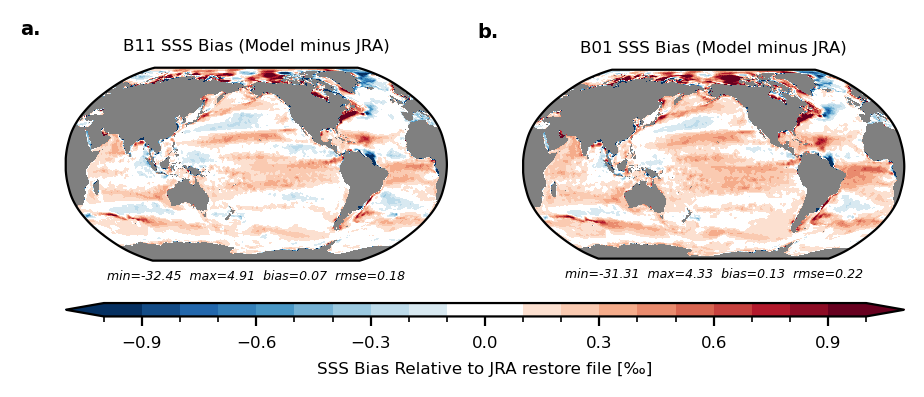

In [17]:
# Loop over regions and make maps

for reg in reg_settings.keys():

    print(f"Processing region: {reg}")
    settings = reg_settings[reg]

    # make plots for regions
    if reg in diag.diag_vars["plot_region"]:
        nexps = len(diag.groups)
        figsize, subplot = nbtools.get_figsize_subplots(nexps)

        results = []
        fig = plt.figure(figsize=figsize, dpi=200)
        cmap, norm, boundaries = nbtools.gen_levs_and_cmap(*settings["levels"])
        projection = settings["projection"]

        for n, k in enumerate(annual.keys()):
            arr = annual[k]
            obs = obs_om4 if "om4" in arr.model else obs_om5
            if settings["xrange"] is not None or settings["yrange"] is not None:
                arr = momgrid.geoslice.geoslice(
                    arr, x=settings["xrange"], y=settings["yrange"]
                )
                obs = momgrid.geoslice.geoslice(
                    obs, x=settings["xrange"], y=settings["yrange"]
                )
            ax = plt.subplot(*subplot, n + 1, projection=projection, facecolor="gray")
            res = plot_map_panel(ax, arr, obs, cmap, norm, label=k.upper())
            results.append(res)

        axes, cbs, stats = zip(*results)

        plt.subplots_adjust(hspace=settings["hspace"])

        cbar = nbtools.bottom_colorbar(
            fig, cbs[0], orientation="horizontal", extend="both"
        )
        cbar.set_label(f"SSS Bias Relative to JRA restore file [{chr(0x2030)}]")

        # add letter labels for each panel
        nbtools.panel_letters(axes, -0.12, 1.17)

        # append figure to the complete list of figures
        all_figs.append(fig)

    # for regions that are not plotted, still calculate the statistics
    else:
        results = []
        for n, k in enumerate(annual.keys()):
            arr = annual[k]
            obs = obs_om4 if "om4" in arr.model else obs_om5
            if settings["xrange"] is not None or settings["yrange"] is not None:
                arr = momgrid.geoslice.geoslice(
                    arr, x=settings["xrange"], y=settings["yrange"]
                )
                obs = momgrid.geoslice.geoslice(
                    obs, x=settings["xrange"], y=settings["yrange"]
                )

            res = nbtools.calculate_stats(arr, obs, arr.areacello)
            results.append(res)

        stats, _ = zip(*results)

    # register statistics
    for n, grp in enumerate(diag.groups):
        for k, v in stats[n].items():
            metric = (k, float(v))
            grp.add_metric(reg, metric)

### Seasonal Cycle

In [28]:
# Load SST observations
time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
dsobs_om4 = xr.open_dataset(
            "/archive/gold/datasets/OM4_025/INPUT.JRA.v2019.07.04/salt_restore_JRA.1440x1080.v20190706.nc",
           decode_times=False)
dsobs_om4 = dsobs_om4.rename({"i":"xh","j":"yh","IQ":"xq","JQ":"yq"}) 
dsobs_om5 = xr.open_dataset(
            "/archive/gold/datasets/OM5_025/INPUT/salt_restore_JRA_v20240410.nc",
            decode_times=False)
dsobs_om5 = dsobs_om5.rename({"i":"xh","j":"yh","IQ":"xq","JQ":"yq"}) 
dsobs = {"om4": momgrid.Gridset(dsobs_om4).data,"om5": momgrid.Gridset(dsobs_om5).data}

obs_om5 = dsobs["om5"].sos
obs_om4 = dsobs["om4"].sos

In [29]:
# loop over experiments and make the annual cycle
anncyc = {}
for k, v in exps.items():
    ds = v.datasets[variables[0]]
    arr = ds["tos"]
    arr = ml.util.annual_cycle(arr).load()
    arr.attrs["model"] = ds.model
    anncyc[k] = arr

AttributeError: 'list' object has no attribute 'items'

In [ ]:
# function to plot a single seasonal cycle panel


def plot_panel(ax, arr, obs, vmin=-1, vmax=1, label=""):
    time = np.arange(1, 13)
    area = arr.areacello
    lat = arr.geolat.mean("xh")

    arr = arr.assign_coords({"time": time})
    arr = arr.weighted(area).mean("xh")

    obs = obs.assign_coords({"time": time})
    obs = obs.weighted(area).mean("xh")

    diff = arr - obs

    dpm = np.array(
        [31.0, 28, 31.0, 30.0, 31.0, 30.0, 31.0, 31.0, 30.0, 31.0, 30.0, 31.0]
    )
    coslat = np.cos(np.deg2rad(lat))
    x, y = np.meshgrid(dpm, coslat)
    wgt = (diff * 0.0) + (x * y).T
    wgt = wgt.fillna(0.0)

    levels = np.arange(-1, 1.1, 0.1)
    cb = ax.contourf(
        diff.time, lat, diff.T, levels=levels, cmap="RdBu_r", extend="both"
    )
    ax.set_title(f"{label} SST Bias (Model minus NOAA OISSTv2)")

    ax.set_xticks(np.arange(1, 13))
    ax.set_xticklabels(["J", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"])

    orig_stats, stats_str = nbtools.calculate_stats(arr, obs, wgt)
    stats = {k: f"{round(float(v),2)}" for k, v in orig_stats.items()}
    del [stats["rsquared"]]
    stats_str = str("  ").join([f"{k}={v}" for k, v in stats.items()])
    ax.text(0.5, -0.15, stats_str, ha="center", style="italic", transform=ax.transAxes)
    ax.grid(True, color="k", linestyle=":", linewidth=0.5)

    ax.set_ylim(-78, None)

    return (ax, cb, stats)

In [ ]:
nexps = len(diag.groups)
figsize, subplot = nbtools.get_figsize_subplots(nexps)

results = []
fig = plt.figure(figsize=figsize, dpi=200)

for n, k in enumerate(annual.keys()):
    arr = anncyc[k]
    obs = obs_om4 if "om4" in arr.model else obs_om5
    ax = plt.subplot(*subplot, n + 1, facecolor="gray")
    res = plot_panel(ax, arr, obs, label=k.upper())
    results.append(res)

plt.subplots_adjust(hspace=0.3)

axes, cbs, stats = zip(*results)

cbar = nbtools.bottom_colorbar(fig, cbs[0], orientation="horizontal", extend="both")
cbar.set_label("Sea Surface Temperature Bias [degC]")

# add letter labels for each panel
nbtools.panel_letters(axes)

# register statistics
for n, grp in enumerate(diag.groups):
    for k, v in stats[n].items():
        metric = (k, float(v))
        grp.add_metric("zonal_seas_cycle", metric)

all_figs.append(fig)

### Maps by Season

In [25]:
seasons = {
    "DJF": [11, 0, 1],
    "MAM": [2, 3, 4],
    "JJA": [5, 6, 7],
    "SON": [8, 9, 10],
}

In [26]:
for season in seasons.keys():

    nexps = len(diag.groups)
    figsize, subplot = nbtools.get_figsize_subplots(nexps)

    results = []
    fig = plt.figure(figsize=figsize, dpi=200)

    cmap, norm, boundaries = nbtools.gen_levs_and_cmap(-7, 7.5, 0.5)
    projection = ccrs.Robinson(central_longitude=-160)

    for n, k in enumerate(anncyc.keys()):
        arr = anncyc[k]
        obs = obs_om4 if "om4" in arr.model else obs_om5
        arr = arr.isel(time=seasons[season]).mean("time")
        obs = obs.isel(time=seasons[season]).mean("time")
        ax = plt.subplot(*subplot, n + 1, projection=projection, facecolor="gray")
        res = plot_map_panel(ax, arr, obs, cmap, norm, label=f"{k.upper()} {season}")
        results.append(res)

    axes, cbs, stats = zip(*results)

    cbar = nbtools.bottom_colorbar(fig, cbs[0], orientation="horizontal", extend="both")
    cbar.set_label("Sea Surface Salinity Bias [$\\permill$]")

    # add letter labels for each panel
    nbtools.panel_letters(axes)

    # register statistics
    for n, grp in enumerate(diag.groups):
        for k, v in stats[n].items():
            metric = (k, float(v))
            grp.add_metric(f"{str(season).lower()}_bias", metric)

    all_figs.append(fig)

NameError: name 'anncyc' is not defined

<Figure size 1082x670 with 0 Axes>

In [9]:
### SSS Trend

In [ ]:
# Load SST observations
time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
dsobs = {
    "om4": momgrid.Gridset(
        xr.open_dataset(
            # "/archive/jpk/datasets/observations/NOAA-OISST/processed/NOAA_OISST_v2_annual_199101_202012_v20250722_OM4.nc",
            "/archive/gold/datasets/OM4_025/INPUT.JRA.v2019.07.04/salt_restore_JRA.1440x1080.v20190706.nc"
            decode_times=time_coder,
        )
    ).data,
    "om5": momgrid.Gridset(
        xr.open_dataset(
#            "/archive/jpk/datasets/observations/NOAA-OISST/processed/NOAA_OISST_v2_annual_199101_202012_v20250722_OM5.nc",
            "/archive/gold/datasets/OM5_025/INPUT/salt_restore_JRA_v20240410.nc"
            decode_times=time_coder,
        )
    ).data,
}

obs_om5 = dsobs["om5"].tos
obs_om4 = dsobs["om4"].tos

In [ ]:
obs_slope_om5 = ml.trend.calc_linear_trend(obs_om5, time_units="yr")["tos_slope"].load()

In [ ]:
# plot observed trend

fig = plt.figure(figsize=(nbtools.SINGLE_COLUMN, nbtools.SINGLE_COLUMN), dpi=200)
ax = plt.subplot(
    1, 1, 1, projection=ccrs.Robinson(central_longitude=-160), facecolor="gray"
)
cmap, norm, boundaries = nbtools.gen_levs_and_cmap(-0.1, 0.11, 0.01)
cb = ax.pcolormesh(
    obs_om5.geolon,
    obs_om5.geolat,
    obs_slope_om5,
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    norm=norm,
)
ax.set_title("NOAA OISSTv2 1991-2020")
cbar = nbtools.bottom_colorbar(fig, cb, orientation="horizontal", extend="both")
cbar.set_label("Sea Surface Temperature Trend [degC yr-1]")

all_figs.append(fig)

In [ ]:
# loop over experiments and make the annual cycle
modtrend = {}
for k, v in exps.items():
    ds = v.datasets[variables[0]]
    arr = ml.util.annual_average(ds["sos"])
    trend = ml.trend.calc_linear_trend(arr, time_units="yr")["sos_slope"].load()
    trend.attrs["model"] = ds.model
    trend = trend.assign_coords(
        {"geolon": ds.geolon, "geolat": ds.geolat, "areacello": ds.areacello}
    )
    modtrend[k] = trend

In [ ]:
for reg in reg_settings.keys():

    print(f"Processing region: {reg}")
    settings = reg_settings[reg]

    # make plots for regions
    if reg in diag.diag_vars["plot_region"]:
        nexps = len(diag.groups)
        figsize, subplot = nbtools.get_figsize_subplots(nexps)

        results = []
        fig = plt.figure(figsize=figsize, dpi=200)
        cmap, norm, boundaries = nbtools.gen_levs_and_cmap(-0.1, 0.11, 0.01)
        projection = settings["projection"]

        for n, k in enumerate(annual.keys()):
            arr = modtrend[k]
            if settings["xrange"] is not None or settings["yrange"] is not None:
                arr = momgrid.geoslice.geoslice(
                    arr, x=settings["xrange"], y=settings["yrange"]
                )
            ax = plt.subplot(*subplot, n + 1, projection=projection, facecolor="gray")
            ax, cb, _ = plot_map_panel(
                ax, arr, cmap=cmap, norm=norm, label=k.upper(), stats=False
            )
            ax.set_title(f"{k.upper()} SST Trend 1991-2020")
            avg_trend = arr.weighted(arr.areacello).mean(("yh", "xh"))
            stat = {"trend": float(avg_trend)}
            results.append((ax, cb, stat))

        axes, cbs, stats = zip(*results)

        cbar = nbtools.bottom_colorbar(fig, cb, orientation="horizontal", extend="both")
        cbar.set_label("Sea Surface Temperature Trend [degC yr-1]")

        all_figs.append(fig)

    # for regions that are not plotted, still calculate the statistics
    else:
        stats = []
        for n, k in enumerate(annual.keys()):
            arr = modtrend[k]
            if settings["xrange"] is not None or settings["yrange"] is not None:
                arr = momgrid.geoslice.geoslice(
                    arr, x=settings["xrange"], y=settings["yrange"]
                )
            avg_trend = arr.weighted(arr.areacello).mean(("yh", "xh"))
            stats.append({"trend": float(avg_trend)})

    # register statistics
    for n, grp in enumerate(diag.groups):
        for k, v in stats[n].items():
            metric = (k, float(v))
            grp.add_metric(f"{reg}_trend", metric)

### Process and synthesize metrics

In [19]:
data = diag.metrics
exps = list(data["RESULTS"]["Global"].keys())
metrics = list(data["RESULTS"]["Global"][exps[0]].keys())
trends = set([x for x in metrics if "_trend" in x])
seasonal = set(
    [x for x in metrics if "_bias" in x] + [x for x in metrics if "_seas_cycle" in x]
)
regions = set(metrics) - trends - seasonal

In [20]:
results = {}
for exp in exps:
    results[exp] = {}
    for reg in regions:
        x = data["RESULTS"]["Global"][exp][reg]["bias"]
        results[exp][reg] = x

pd.DataFrame(results)

,om5_b11_nonbouss,om5_b00_dtcpld1800_c5 (b01)
north_atlantic,0.007202,0.05465
peru,0.097740,0.14320
california,0.061970,0.12680
global,0.070000,0.13000
australia,0.087270,0.13330
southern_ocean,0.029520,0.08200
south_atlantic,0.055070,0.11960
nw_pacific,0.028270,0.07959
caribbean,0.054750,0.12120
trop_indopac,0.095340,0.14410


In [21]:
results = {}
for exp in exps:
    results[exp] = {}
    for trend in trends:
        results[exp][trend] = data["RESULTS"]["Global"][exp][trend]["trend"]

pd.DataFrame(results)

,om5_b11_nonbouss,om5_b00_dtcpld1800_c5 (b01)


In [22]:
results = {}
for exp in exps:
    results[exp] = {}
    for seas in seasonal:
        results[exp][seas] = data["RESULTS"]["Global"][exp][seas]["bias"]

pd.DataFrame(results)

,om5_b11_nonbouss,om5_b00_dtcpld1800_c5 (b01)


### Write Metrics to File

In [23]:
diag.write_metrics("SSS_metrics.json")

{
  "DIMENSIONS": {
    "json_structure": [
      "region",
      "model",
      "metric"
    ]
  },
  "RESULTS": {
    "Global": {
      "om5_b11_nonbouss": {
        "global": {
          "min": -32.45,
          "max": 4.91,
          "bias": 0.07,
          "rmse": 0.18
        },
        "arctic": {
          "min": -26.53,
          "max": 4.905,
          "bias": 0.04062,
          "rmse": 0.4183,
          "rsquared": 0.9798
        },
        "southern_ocean": {
          "min": -7.116,
          "max": 0.8949,
          "bias": 0.02952,
          "rmse": 0.08124,
          "rsquared": 0.7308
        },
        "nw_pacific": {
          "min": -29.78,
          "max": 1.396,
          "bias": 0.02827,
          "rmse": 0.1747,
          "rsquared": 0.9097
        },
        "trop_indopac": {
          "min": -26.53,
          "max": 1.174,
          "bias": 0.09534,
          "rmse": 0.1729,
          "rsquared": 0.9418
        },
        "australia": {
          "min": -15.29

### Make a PowerPoint Presentation of Figures

In [24]:
nbtools.save_pptx(all_figs,"SSS_bias.pptx")